# Libraries

In [100]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn import metrics

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Import data

In [101]:
%run Data_preprocessing.ipynb

************************************************************
There are 6 set of X
X_*_nozero
------------------------------------------------------------
Normalized version
X_*_norm
------------------------------------------------------------
There are 4 set of Y
y_train_t1, y_train_t2, y_valid_t1, y_valid_t2
when training, please use: 'y_train_t1_value,y_train_t2_value,y_valid_t1_value,y_valid_t2_value'
************************************************************


In [102]:
print(X_train_norm.shape)
print(X_valid_norm.shape)
print(X_test_norm.shape)

(16760, 61)
(2394, 61)
(4790, 61)


# Imbalanced Learning

In [103]:
Full = pd.DataFrame(np.concatenate((X_train_norm,pd.DataFrame(y_train_t1.iloc[:,-1])),axis=1))
Full

label0 = Full[Full[61]==0]
label1 = Full[Full[61]==1]
print(label0.shape,label1.shape)

(15535, 62) (1225, 62)


In [104]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler()
x_over, y_over = oversample.fit_resample(X_train_norm, y_train_t1.iloc[:,-1])


y_over = pd.DataFrame(y_over)
y_over.shape
x_over.shape

(31070, 61)

In [105]:
Full = pd.DataFrame(np.concatenate((x_over,y_over),axis=1))
Full

label0 = Full[Full[61]==0]
label1 = Full[Full[61]==1]
print(label0.shape,label1.shape)

(15535, 62) (15535, 62)


In [106]:
X_train_norm=x_over

y_train_t1 = y_over

# Neural Network Using Sklearn build in function

In [107]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

clf = MLPClassifier(solver="lbfgs",
                    alpha=1e-5,
                    hidden_layer_sizes=(5,2),
                    random_state=1,
                    max_iter=200)

clf.fit(X_train_norm, y_train_t1)

clf.score(X_valid_norm, y_valid_t1_value)

0.7472848788638262

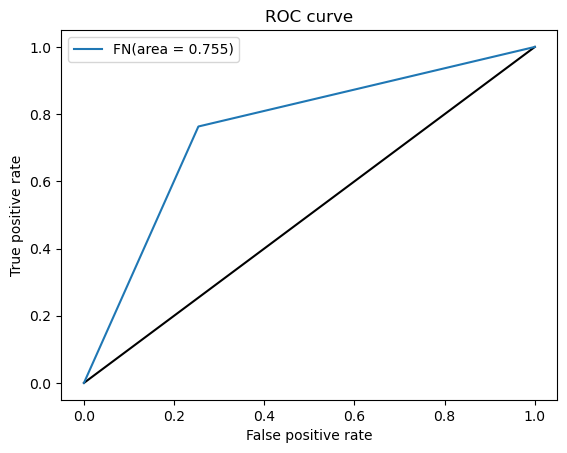

In [108]:
y_pred = clf.predict(X_valid_norm)
fpr, tpr, _ = metrics.roc_curve(y_valid_t1_value, y_pred)
roc_auc = metrics.roc_auc_score(y_valid_t1_value, y_pred)



plt.figure(1)
plt.plot([0, 1], [0, 1], 'k-')
plt.plot(fpr, tpr, label='FN(area = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title("ROC curve")
plt.legend(loc="best")
plt.show()

# Hyperparameter and setting tuning

## layers

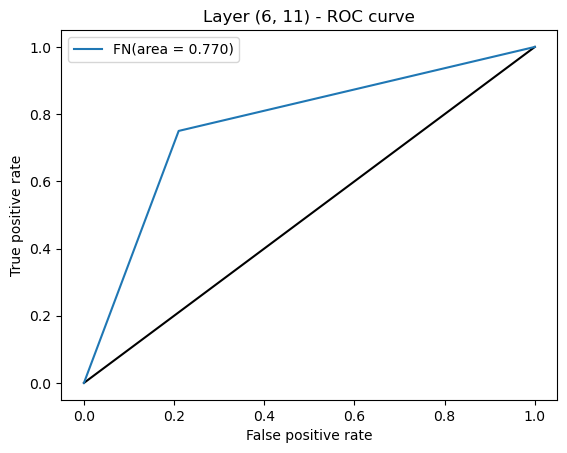

In [109]:
layer_list = []
fpr_lst=[]
tpr_lst=[]
roc_auc_lst=[]
for i in range(1,20,5):
    for j in range(1,20,5):
        layer_list.append((i,j))
        
for i in layer_list:
    clf = MLPClassifier(solver="lbfgs",
                        alpha=1e-5,
                        hidden_layer_sizes=i,
                        random_state=1,
                        max_iter=200)

    clf.fit(X_train_norm, y_train_t1)
    clf.score(X_valid_norm, y_valid_t1_value)
    y_pred = clf.predict(X_valid_norm)
    fpr, tpr, _ = metrics.roc_curve(y_valid_t1_value, y_pred)
    roc_auc = metrics.roc_auc_score(y_valid_t1_value, y_pred)
    
    fpr_lst.append(fpr)
    tpr_lst.append(tpr)
    roc_auc_lst.append(roc_auc)
    
    
index = roc_auc_lst.index(max(roc_auc_lst))
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k-')
plt.plot(fpr_lst[index], tpr_lst[index], label='FN(area = {:.3f})'.format(max(roc_auc_lst)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title(f"Layer {layer_list[index]} - ROC curve")
plt.legend(loc="best")
plt.show()

In [112]:
best_layernumber = layer_list[index]
best_layernumber

(6, 11)

## Solver

<Figure size 500x500 with 0 Axes>

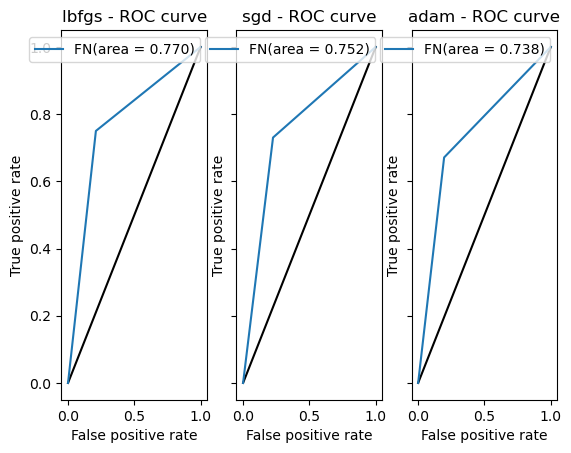

In [113]:
solver_list = ["lbfgs","sgd","adam"]
fpr_lst=[]
tpr_lst=[]
roc_auc_lst=[]

for i in solver_list:
    clf = MLPClassifier(solver=i,
                        alpha=1e-5,
                        hidden_layer_sizes=best_layernumber,
                        random_state=1,
                        max_iter=200)

    clf.fit(X_train_norm, y_train_t1)
    clf.score(X_valid_norm, y_valid_t1_value)
    y_pred = clf.predict(X_valid_norm)
    fpr, tpr, _ = metrics.roc_curve(y_valid_t1_value, y_pred)
    roc_auc = metrics.roc_auc_score(y_valid_t1_value, y_pred)
    
    fpr_lst.append(fpr)
    tpr_lst.append(tpr)
    roc_auc_lst.append(roc_auc)
    
    
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True)
plt.figure(figsize=(5,5))
for j in range(3):
    plt.figure(1)
    axes[j].plot([0, 1], [0, 1], 'k-')
    axes[j].plot(fpr_lst[j], tpr_lst[j], label='FN(area = {:.3f})'.format(roc_auc_lst[j]))
    axes[j].set_xlabel('False positive rate')
    axes[j].set_ylabel('True positive rate')
    axes[j].set_title(f"{solver_list[j]} - ROC curve")
    axes[j].legend(loc="best")
plt.show()

In [115]:
index = roc_auc_lst.index(max(roc_auc_lst))
best_solver = solver_list[index]
best_solver

'lbfgs'

## Learning rate tuning

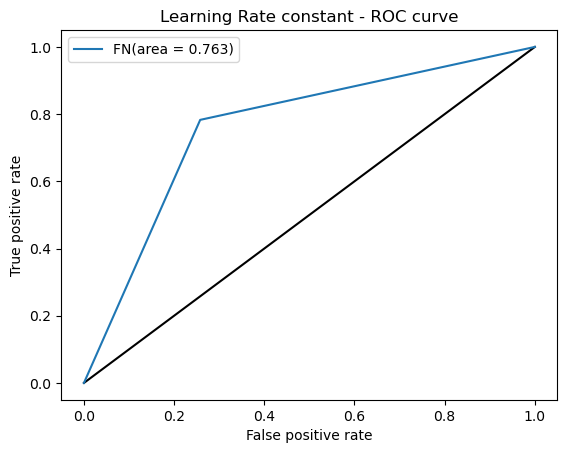

In [125]:
fpr_lst=[]
tpr_lst=[]
roc_auc_lst=[]
lr_list = ["constant", "invscaling", "adaptive"]

for i in lr_list:
    clf = MLPClassifier(solver=best_solver,
                        alpha=1e-5,
                        hidden_layer_sizes=best_layernumber,
                        learning_rate=i,
                        random_state=3612,
                        max_iter=200)

    clf.fit(X_train_norm, y_train_t1)
    clf.score(X_valid_norm, y_valid_t1_value)
    y_pred = clf.predict(X_valid_norm)
    fpr, tpr, _ = metrics.roc_curve(y_valid_t1_value, y_pred)
    roc_auc = metrics.roc_auc_score(y_valid_t1_value, y_pred)
    
    fpr_lst.append(fpr)
    tpr_lst.append(tpr)
    roc_auc_lst.append(roc_auc)
    
    
index = roc_auc_lst.index(max(roc_auc_lst))
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k-')
plt.plot(fpr_lst[index], tpr_lst[index], label='FN(area = {:.3f})'.format(max(roc_auc_lst)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title(f"Learning Rate {lr_list[index]} - ROC curve")
plt.legend(loc="best")
plt.show()

In [126]:
index = roc_auc_lst.index(max(roc_auc_lst))
best_lr_choice =  lr_list[index]
best_lr_choice

'constant'

## Regularization rate

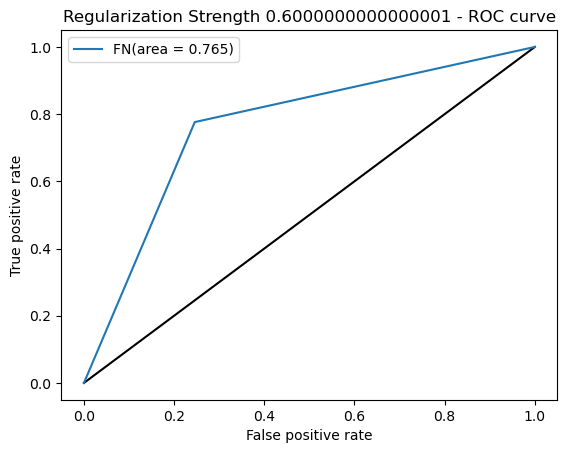

In [132]:

fpr_lst=[]
tpr_lst=[]
roc_auc_lst=[]
reg_list = np.linspace(0,1,11)

for i in reg_list:
    clf = MLPClassifier(solver=best_solver,
                        alpha=i,
                        hidden_layer_sizes=best_layernumber,
                        learning_rate=best_lr_choice,
                        random_state=3612,
                        max_iter=200)

    clf.fit(X_train_norm, y_train_t1)
    clf.score(X_valid_norm, y_valid_t1_value)
    y_pred = clf.predict(X_valid_norm)
    fpr, tpr, _ = metrics.roc_curve(y_valid_t1_value, y_pred)
    roc_auc = metrics.roc_auc_score(y_valid_t1_value, y_pred)
    
    fpr_lst.append(fpr)
    tpr_lst.append(tpr)
    roc_auc_lst.append(roc_auc)
    
    
index = roc_auc_lst.index(max(roc_auc_lst))
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k-')
plt.plot(fpr_lst[index], tpr_lst[index], label='FN(area = {:.3f})'.format(max(roc_auc_lst)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title(f"Regularization Strength {reg_list[index]} - ROC curve")
plt.legend(loc="best")
plt.show()

# Final Model

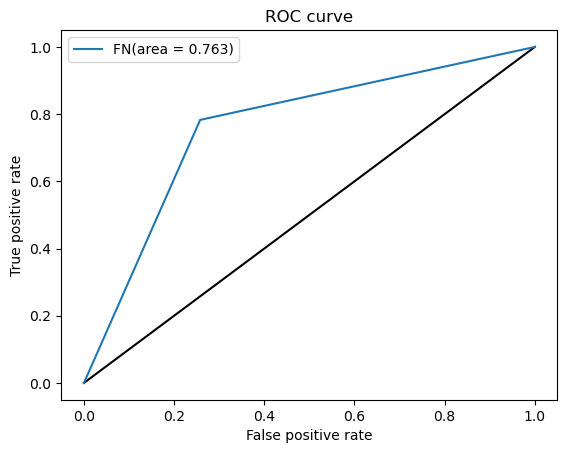

In [127]:
# Final model
clf1 = MLPClassifier(solver=best_solver,
                    alpha=1e-5,
                    hidden_layer_sizes=best_layernumber,
                    learning_rate=best_lr_choice,
                    random_state=3612,
                    max_iter=200)

clf1.fit(X_train_norm, y_train_t1)

clf1.score(X_valid_norm, y_valid_t1_value)
y_pred = clf1.predict(X_valid_norm)
fpr, tpr, _ = metrics.roc_curve(y_valid_t1_value, y_pred)
roc_auc = metrics.roc_auc_score(y_valid_t1_value, y_pred)



plt.figure(1)
plt.plot([0, 1], [0, 1], 'k-')
plt.plot(fpr, tpr, label='FN(area = {:.3f})'.format(roc_auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title("ROC curve")
plt.legend(loc="best")
plt.show()

# Test

In [128]:
X_test_norm

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.000000,2.882147e-18,0.000000,0.193160,6.016953e-17,5.609774e-18,0.971208,-2.477535e-17,-0.700754,-0.085412,...,-1.094667,0.761543,-0.269197,0.796149,-2.749614e+00,3.198461e+00,-5.959798e-01,4.188770e-17,-1.662156e-17,0.766021
1,-0.312102,1.723721e+00,-0.090785,-1.308996,-2.810434e-01,-3.818694e-01,1.211987,-3.767748e-01,-0.343800,-0.015321,...,0.000000,0.298294,-0.175260,0.057241,3.604995e-17,3.454719e-17,1.042083e-17,4.188770e-17,-1.521141e-01,2.209922
2,-0.284284,1.005956e+00,0.385820,0.193160,-2.930417e-01,-7.992430e-01,0.730430,-5.511088e-01,-0.547773,0.405221,...,0.000000,-0.164956,1.186824,-1.226029,3.604995e-17,3.454719e-17,1.042083e-17,4.188770e-17,-6.449774e-01,-0.527474
3,0.000000,2.882147e-18,0.000000,-0.708134,6.016953e-17,5.609774e-18,-0.232683,-2.477535e-17,0.013154,0.000000,...,-2.765092,-0.396581,-0.410103,1.418316,1.164973e+00,1.111059e+00,5.531141e-02,4.188770e-17,2.380694e-01,-0.632759
4,-0.337139,2.882147e-18,-0.155191,-0.708134,-2.981838e-01,2.539745e+00,-0.232683,-5.511088e-01,-0.343800,-0.786317,...,0.000000,0.298294,-1.584314,1.184969,3.604995e-17,3.454719e-17,1.042083e-17,4.188770e-17,-1.662156e-17,-1.550237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4785,0.000000,2.882147e-18,0.000000,-0.407702,6.016953e-17,5.609774e-18,1.452765,-2.477535e-17,0.013154,0.545402,...,-3.878709,-0.396581,-1.255535,-0.214951,-7.502785e-01,-5.672995e+00,-1.799938e-01,4.188770e-17,-1.091635e+00,-0.346986
4786,0.000000,2.882147e-18,0.000000,0.493592,6.016953e-17,5.609774e-18,-1.195797,-2.477535e-17,2.103882,0.335131,...,0.000000,-2.017954,0.951982,-0.603824,3.604995e-17,3.454719e-17,1.042083e-17,-5.910209e-01,-4.692437e-01,0.029029
4787,0.000000,2.882147e-18,0.000000,-0.407702,6.016953e-17,5.609774e-18,-0.714240,-2.477535e-17,-0.751747,0.000000,...,0.297353,-0.396581,-0.316166,0.718344,-8.250200e-01,6.735880e-02,-1.799938e-01,4.188770e-17,4.074914e-01,-0.256743
4788,0.000000,2.882147e-18,0.000000,1.094454,6.016953e-17,-1.216617e+00,-0.232683,-2.477535e-17,0.472094,0.265040,...,0.000000,0.529918,1.139856,-0.914922,3.604995e-17,3.454719e-17,1.042083e-17,-5.283017e-01,-6.449774e-01,1.096915


In [129]:

result = clf1.predict(X_test_norm)
res1 = pd.DataFrame(result.tolist(), columns=["Predicted"])
res1.index = X_test.index
res1.index.name = 'Id'
pd.DataFrame(res1).to_csv('out.csv')
#print(torch.count_nonzero(torch.from_numpy(np.array(res1)).to(torch.float32)))
res1.sum(axis=0)

Predicted    1337
dtype: int64